<a href="https://colab.research.google.com/github/DevourAI/vstar/blob/main/CLIP_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Interacting with CLIP

This is a self-contained notebook that shows how to download and run CLIP models, calculate the similarity between arbitrary image and text inputs, and perform zero-shot image classifications.

# Preparation for Colab

Make sure you're running a GPU runtime; if not, select "GPU" as the hardware accelerator in Runtime > Change Runtime Type in the menu. The next cells will install the `clip` package and its dependencies, and check if PyTorch 1.7.1 or later is installed.

In [3]:
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 474.4 kB/s eta 0:00:00
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-hiw5lr2r
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-hiw5lr2r
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=be4e6fa9a68eabcfb676a5779a52a704e5f960e4b9be51b25d077d5a546359c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-2tkjkg3t/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [48]:
import numpy as np
import torch
from pkg_resources import packaging
import torchvision.transforms as transforms
import matplotlib.pyplot as pltimport
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

print("Torch version:", torch.__version__)



cuda:0
Torch version: 2.1.0+cu121


In [44]:
# ##DOWNLOAD imagenet

# import os
# from google.colab import drive
# drive.mount('/content/drive')
# checkpoints = '/content/drive/MyDrive/colab_files/imagenet64/'
# if not os.path.exists(checkpoints):
#     os.makedirs(checkpoints)

# import os
# import shutil
# if not os.path.exists('imagenet64'):
#   if not os.path.exists(checkpoints + 'imagenet64.tar'):
#     print("Downloading archive...")
#     os.chdir(checkpoints)
#     !wget https://pjreddie.com/media/files/imagenet64.tar
#     os.chdir('/content/')
#   print("Copying to local runtime...")
#   shutil.copy(checkpoints + 'imagenet64.tar', './imagenet64.tar')
#   print("Uncompressing...")
#   !tar -xf imagenet64.tar
# print("Data ready!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
--2024-01-20 23:59:11--  https://pjreddie.com/media/files/imagenet64.tar
Resolving pjreddie.com (pjreddie.com)... 162.0.215.52
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10033909760 (9.3G) [application/x-tar]
Saving to: ‘imagenet64.tar’

imagenet64.tar        5%[>                   ] 500.15M  --.-KB/s    in 22s     

2024-01-20 23:59:34 (22.7 MB/s) - Connection closed at byte 524447937. Retrying.

--2024-01-20 23:59:35--  (try: 2)  https://pjreddie.com/media/files/imagenet64.tar
Connecting to pjreddie.com (pjreddie.com)|162.0.215.52|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10033909760 (9.3G) [application/x-tar]
Saving to: ‘imagenet64.tar’

imagenet64.tar        3%[                    ] 358.09M  40.4MB/s    eta 3m 37s ^C
Copying to local runti

# Loading the model

`clip.available_models()` will list the names of available CLIP models.

In [5]:
import clip

clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [49]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


# Image Preprocessing

We resize the input images and center-crop them to conform with the image resolution that the model expects. Before doing so, we will normalize the pixel intensity using the dataset mean and standard deviation.

The second return value from `clip.load()` contains a torchvision `Transform` that performs this preprocessing.



In [50]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x78d0f20a1510>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

# Text Preprocessing

We use a case-insensitive tokenizer, which can be invoked using `clip.tokenize()`. By default, the outputs are padded to become 77 tokens long, which is what the CLIP models expects.

In [8]:
clip.tokenize("Hello World!")

tensor([[49406,  3306,  1002,   256, 49407,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Setting up input images and texts

We are going to feed 8 example images and their textual descriptions to the model, and compare the similarity between the corresponding features.

The tokenizer is case-insensitive, and we can freely give any suitable textual descriptions.

In [127]:
import os
import skimage
import IPython.display
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from collections import OrderedDict
import torch

# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# New Section

In [128]:
original_images = []
images = []
texts = []
plt.figure(figsize=(18, 5))

for filename in [filename for filename in os.listdir('/content/drive/MyDrive/images/') if filename.endswith(".png") or filename.endswith(".jpg")]:
    name = os.path.splitext(filename)[0]
    image = Image.open(os.path.join('/content/drive/MyDrive/images/', filename)).convert("RGB")
    original_images.append(image)
    images.append(preprocess(image))


<Figure size 1800x500 with 0 Axes>

## Building features

We normalize the images, tokenize each text input, and run the forward pass of the model to get the image and text features.

# Zero-Shot Image Classification

You can classify images using the cosine similarity (times 100) as the logits to the softmax operation.

In [131]:
from torchvision.datasets import CIFAR100

# ImageNet = ImageNet(os.path.expanduser("~/.cache"), transform=preprocess, download=True)
cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=True)

Files already downloaded and verified


In [132]:
image_input = torch.tensor(np.stack(images)).cuda()
text_descriptions = [f"This is a photo of a {label}" for label in cifar100.classes]
text_tokens = clip.tokenize(text_descriptions).cuda()

In [133]:

with torch.no_grad():
    image_features = model.encode_image(image_input).float()
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)

text_probs = (100.0 * image_features @ text_features.T).softmax(dim=-1)
top_probs, top_labels = text_probs.cpu().topk(5, dim=-1)

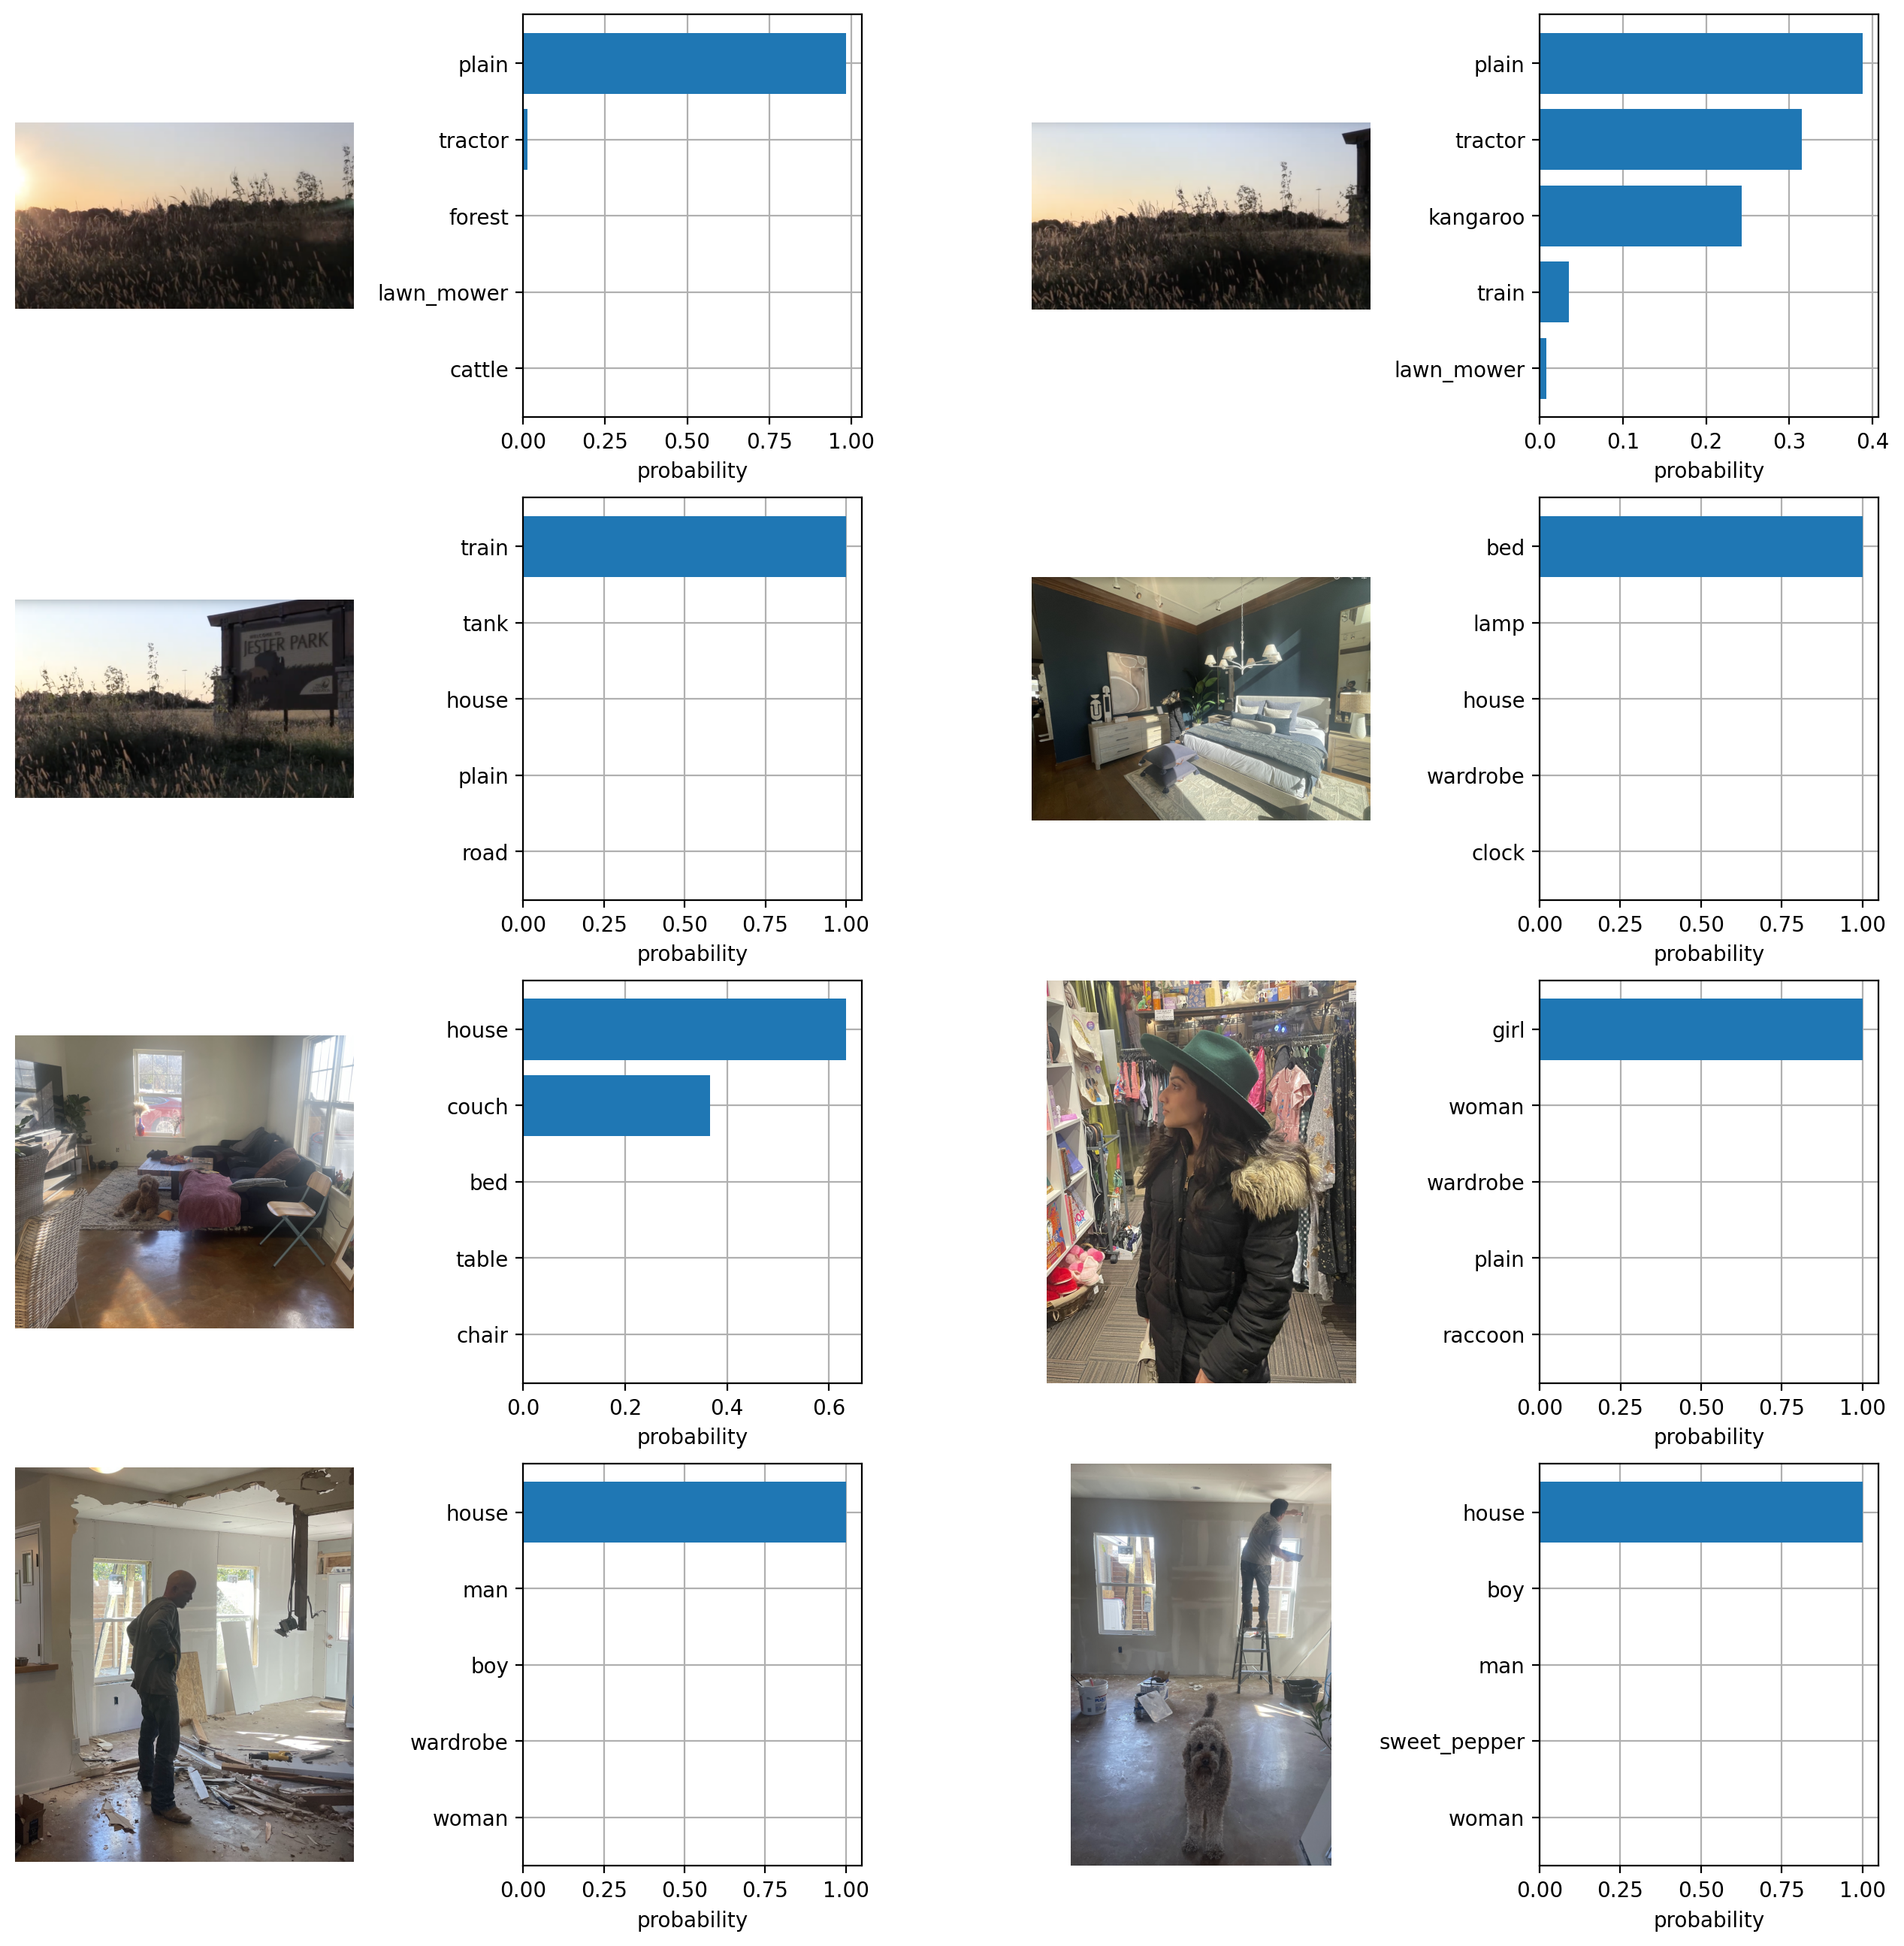

In [134]:
plt.figure(figsize=(16, 16))

for i, image in enumerate(original_images):
    plt.subplot(4, 4, 2 * i + 1)
    plt.imshow(image)
    plt.axis("off")

    plt.subplot(4, 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[i])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[i].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()